# Road to Generative AI - Part 1

## Introduction

The purpose of this notebook is to explore the capabilities of Generative AI. In this first part, we will focus on the most basic form of Generative AI, which is the generation of simple words. We will use a series of model architectures from simple bigram models to more complex RNNs and LSTMs to generate new words based on a dataset of existing words.

## Dataset

For this task, we will build a model that will help us generate new names for the Lord of the Rings universe. We will use the names of the characters in the Lord of the Rings series as our dataset. Our source data can be found [here](https://www.kaggle.com/paultimothymooney/lord-of-the-rings-data).

In [1]:
DATASET_PATH = "./datasets/lotr/lotr_characters_names.csv"

characters = open(DATASET_PATH, "r").read().splitlines()

print(characters[0:10])
print(f"There are {len(characters)} characters in the dataset.")

min_length = map(len, characters)
max_length = map(len, characters)
print(f"The shortest character name has {min(min_length)} characters.")
print(f"The longest character name has {max(max_length)} characters.")

['Adanel', 'Boromir', 'Lagduf', 'Tarcil', 'Fire drake of Gondolin', 'Ar Adûnakhôr', 'Annael', 'Angrod', 'Angrim', 'Anárion']
There are 905 characters in the dataset.
The shortest character name has 3 characters.
The longest character name has 31 characters.


In [2]:
from unidecode import unidecode

def clean_name(name):
    # Remove leading and trailing whitespaces
    # Convert to lowercase
    # Remove accents
    # Remove special characters
    # Replace spaces with underscores

    name = name.strip().lower()
    name = name.replace(" ", "_")
    name = unidecode(name)
    return name

characters = list(map(clean_name, characters))

print(characters[0:10])

['adanel', 'boromir', 'lagduf', 'tarcil', 'fire_drake_of_gondolin', 'ar_adunakhor', 'annael', 'angrod', 'angrim', 'anarion']


## Bigram Model

The simplest form of Generative AI is the bigram model. In this model, we calculate the probability of each character in the dataset based on the previous character. We then use these probabilities to generate new characters. Let's start by building a bigram model for our dataset.

A language model leads the conditional probabilities $P(c_i|c_{i-1})$ where $c_i$ is the $i$-th character in the dataset. We can calculate these probabilities by counting the number of times each character appears after the previous character in the dataset. Then at prediction time, we can generate new characters by sampling from the conditional probabilities.

For the name "adanel", the model needs to understand that the first "a" is the first character and that the "l" is the last character. To do so, we are going to add a start/end token `<.>` at the beginning of each name and at end of each name.

In [3]:
SPECIAL_TOKEN = "<.>"

for w in characters[0:1]:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        print(c1, c2)

<.> a
a d
d a
a n
n e
e l
l <.>


Now we generate a dictionary that contains the conditional probabilities for each character in the dataset. We will use this dictionary to generate new names.

In [4]:
bigrams = {}

for w in characters:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        bigram = (c1, c2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1

# print a sample of 5 bigrams
for c1 in list(bigrams.keys())[0:5]:
    print(c1, bigrams[c1])

('<.>', 'a') 101
('a', 'd') 53
('d', 'a') 56
('a', 'n') 184
('n', 'e') 44


In [5]:
print(f"There are {len(bigrams)} bigrams in the dataset.")
print("The most common bigrams are:")
sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[0:5]

There are 433 bigrams in the dataset.
The most common bigrams are:


[(('a', 'r'), 220),
 (('i', 'n'), 209),
 (('r', '<.>'), 190),
 (('a', 'n'), 184),
 (('o', 'r'), 170)]

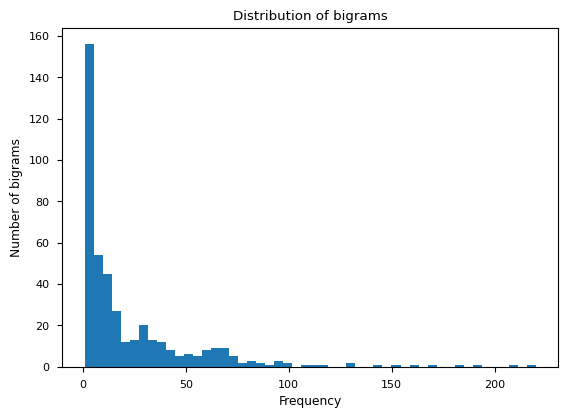

In [6]:
# plot the distribution of bigrams
import matplotlib.pyplot as plt
%matplotlib inline

# set the style
plt.style.use("seaborn-v0_8-paper")

plt.hist(bigrams.values(), bins=50)
plt.xlabel("Frequency")
plt.ylabel("Number of bigrams")
plt.title("Distribution of bigrams")
plt.show()

In [7]:
unique_tokens = set([c for w in characters for c in w])
unique_tokens.add(SPECIAL_TOKEN)
unique_tokens.add(SPECIAL_TOKEN)
N_TOKENS = len(unique_tokens)
print(f"There are {len(unique_tokens)} unique tokens in the dataset.")
print(sorted(unique_tokens))

There are 28 unique tokens in the dataset.
['<.>', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


For efficiency, we are going to use a 2D Pytorch tensor to store the conditional probabilities. The first dimension will represent the previous character, and the second dimension will represent the current character. The value at index `[i, j]` will represent the probability of character `j` appearing after character `i`.

$$N = \begin{bmatrix} P(c_1|c_1) & P(c_2|c_1) & \cdots & P(c_n|c_1) \\ P(c_1|c_2) & P(c_2|c_2) & \cdots & P(c_n|c_2) \\ \vdots & \vdots & \ddots & \vdots \\ P(c_1|c_n) & P(c_2|c_n) & \cdots & P(c_n|c_n) \end{bmatrix}$$

In oder to populate the array, we need a lookup table that maps each character to an index in the array. We will also need a reverse lookup table that maps each index to a character.

In [8]:
# create a mapping from tokens to indices
index_to_token = dict(enumerate(sorted(unique_tokens)))
token_to_index = {v: k for k, v in index_to_token.items()}
# print a few examples
print("Index to token:")
print({k: index_to_token[k] for k in range(10)})

Index to token:
{0: '<.>', 1: '_', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h'}


In [9]:
import torch

# create our bigram array
N = torch.zeros(N_TOKENS, N_TOKENS, dtype=torch.int32)

# populate the bigram array
for w in characters:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        N[token_to_index[c1], token_to_index[c2]] += 1

(-0.5, 27.5, 27.5, -0.5)

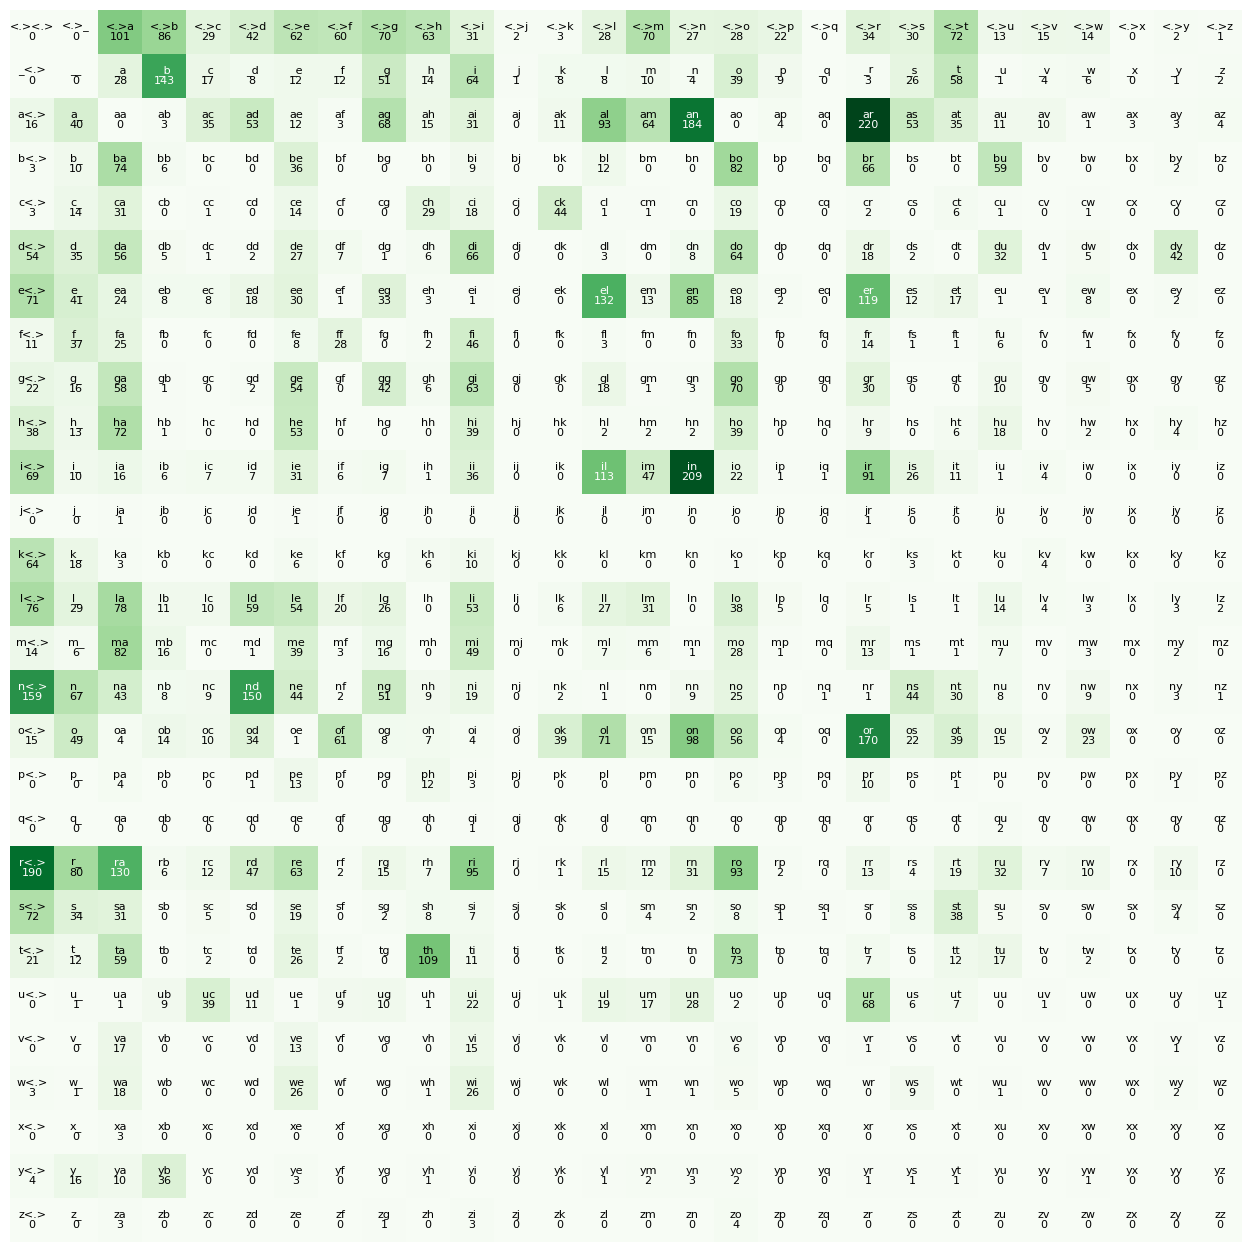

In [16]:
# plot heatmap of bigram array
fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(N, cmap="Greens")
for i in range(N_TOKENS):
    for j in range(N_TOKENS):
        bigram = index_to_token[i] + index_to_token[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color="white" if N[i, j] > N.max() / 2 else "black", fontsize=8)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="white" if N[i, j] > N.max() / 2 else "black", fontsize=8)
plt.axis("off")

In the above chart, the first row represents the count of each character as the first character in the name. The first column represents the count of each character as the last character in the name.

The temperature parameter controls the randomness of the generated names. A higher temperature will result in more random names, while a lower temperature will result in names that are more similar to the original dataset.

In [54]:
def sample_following_token(token: str, temperature: float=1.0):
    # get the row corresponding to the token
    row = N[token_to_index[token], :].float()
    # normalize the row to get probabilities
    probabilities = row / row.sum()
    # apply temperature
    probabilities = probabilities ** (1 / temperature)
    # normalize the adjusted probabilities
    probabilities = probabilities / probabilities.sum()
    # sample from the distribution
    return torch.multinomial(probabilities, 1).item()

In [61]:
print("Here is a sample of 5 tokens following the token 'a':")
sample = [index_to_token[sample_following_token("a")] for _ in range(5)]
print(sample)

Here is a sample of 5 tokens following the token 'a':
['n', 'u', 'n', 'm', 'd']


In [62]:
def generate_name(max_length:int=20, temperature:float=1.0):
    name: str = ""
    previous_token = SPECIAL_TOKEN
    while len(name) < max_length:
        next_token = index_to_token[sample_following_token(previous_token, temperature)]
        if next_token == SPECIAL_TOKEN:
            break
        name += next_token
        previous_token = next_token
    return name.replace("_", " ")

In [66]:
# create a few names
for i in range(10):
    print(generate_name())

avaminainewis on
h
f
cubuiilelamb in
madogo
s
apoi
ol
brndilgid
gan


As we can see, the bigram model is not very effective at generating new names. The names it generates are often nonsensical and do not resemble the names in the dataset. This is because the bigram model does not capture the dependencies between characters in the dataset. To address this issue.

## References

- [Lord of the Rings Data](https://www.kaggle.com/paultimothymooney/lord-of-the-rings-data)